# Source

https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/cvae.ipynb

# Import

In [1]:
# to generate gifs
!pip install imageio

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio

from IPython import display

# Data

In [3]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

In [4]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')

# Normalizing the images to the range of [0., 1.]
train_images /= 255.
test_images /= 255.

# Binarization
train_images[train_images >= .5] = 1.
train_images[train_images < .5] = 0.
test_images[test_images >= .5] = 1.
test_images[test_images < .5] = 0.

In [5]:
TRAIN_BUF = 60000
BATCH_SIZE = 100

TEST_BUF = 10000

In [6]:
# Use *tf.data* to create batches and shuffle the dataset
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(TEST_BUF).batch(BATCH_SIZE)

# Implementation

## Model

In [7]:
class CVAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.inference_net = tf.keras.Sequential(
      [
          tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
          tf.keras.layers.Conv2D(
              filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
          tf.keras.layers.Conv2D(
              filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
          tf.keras.layers.Flatten(),
          # No activation
          tf.keras.layers.Dense(latent_dim + latent_dim),
      ]
    )

    self.generative_net = tf.keras.Sequential(
        [
          tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
          tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
          tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
          tf.keras.layers.Conv2DTranspose(
              filters=64,
              kernel_size=3,
              strides=(2, 2),
              padding="SAME",
              activation='relu'),
          tf.keras.layers.Conv2DTranspose(
              filters=32,
              kernel_size=3,
              strides=(2, 2),
              padding="SAME",
              activation='relu'),
          # No activation
          tf.keras.layers.Conv2DTranspose(
              filters=1, kernel_size=3, strides=(1, 1), padding="SAME"),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.generative_net(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs

    return logits

## Loss and optimizer

In [8]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

@tf.function
def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)

  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def compute_apply_gradients(model, x, optimizer):
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

# Training

In [9]:
# epochs = 100
epochs = 5
latent_dim = 2 # default: 50
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [12]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model.sample(test_input)
  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0], cmap='gray')
      plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

Epoch: 5, Test set ELBO: -161.96649169921875, time elapse for current epoch 2.5376036167144775


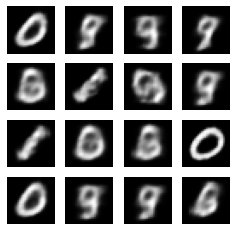

In [13]:
# ランタイムの初回でしかうまくいかない？

generate_and_save_images(model, 0, random_vector_for_generation)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    compute_apply_gradients(model, train_x, optimizer)
  end_time = time.time()

  if epoch % 1 == 0:
    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
      loss(compute_loss(model, test_x))
    elbo = -loss.result()
    display.clear_output(wait=False)
    print('Epoch: {}, Test set ELBO: {}, '
          'time elapse for current epoch {}'.format(epoch,
                                                    elbo,
                                                    end_time - start_time))
    generate_and_save_images(
        model, epoch, random_vector_for_generation)

# Result

## Generate an image

In [14]:
def display_image(epoch_no):
  """Display an image using the epoch number"""
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

(-0.5, 287.5, 287.5, -0.5)

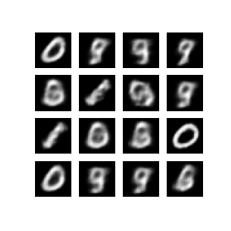

In [15]:
plt.imshow(display_image(epochs))
plt.axis('off')# Display images

## Generate a GIF of all the saved images

In [16]:
anim_file = 'cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info >= (6,2,0,''):
  display.Image(filename=anim_file)

In [17]:
# If you're working in Colab you can download the animation with the code below:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(anim_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 2次元の潜在空間のある範囲の座標に対応する画像を出力

In [18]:
a = np.arange(-1, 1, 0.1)
print(a.shape)
# print(a)
d = a.shape[0]
b = np.zeros([d**2, 2])
print(b.shape)
c = 0
for x in a:
  for y in a:
    b[c, 0] = x
    b[c, 1] = y
    c += 1
# print(b)

(20,)
(400, 2)


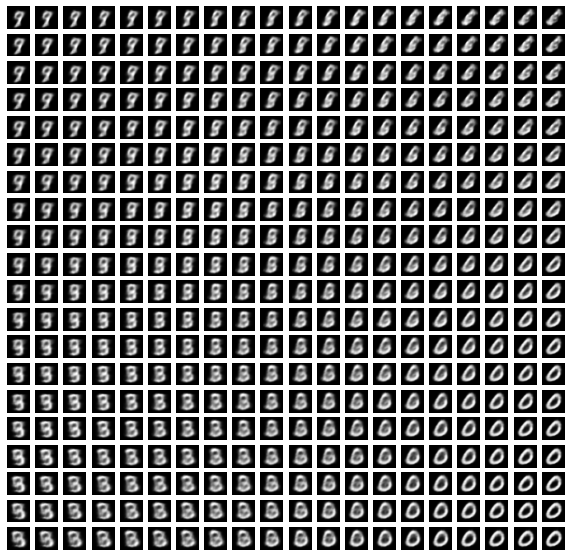

In [19]:
predictions = model.sample(tf.convert_to_tensor(b))
fig = plt.figure(figsize=(10,10))

for i in range(predictions.shape[0]):
    plt.subplot(d, d, i+1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

## 学習済みモデルに潜在変数を与えて画像を出力

潜在変数を潜在空間上で少しずつ移動させて、それぞれの出力をGIFで保存する。  
潜在変数間の間隔を調整することで変化の速度を調整できそう。

In [20]:
# random_vector_for_generation = tf.random.normal(
#     shape=[num_examples_to_generate, latent_dim])
print(random_vector_for_generation.shape)
print(type(random_vector_for_generation))

(16, 2)
<class 'tensorflow.python.framework.ops.EagerTensor'>


In [21]:
predictions.shape

TensorShape([400, 28, 28, 1])

(-0.5, 27.5, 27.5, -0.5)

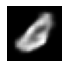

In [22]:
sample_id = 99 # 0 〜 predictions.shape[0]-1
plt.figure(figsize=(1,1))
plt.imshow(predictions[sample_id, :, :, 0], cmap='gray')
plt.axis('off')

In [23]:
e = np.arange(0, 20, 1)
f = np.arange(39, 399+20, 20)
g = np.arange(398, 379, -1)
h = np.arange(360, 0, -20)
print(e, e.shape)
print(f, f.shape)
print(g, g.shape)
print(h, h.shape)
aa = np.concatenate([e,f,g,h])
print(aa.shape)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] (20,)
[ 39  59  79  99 119 139 159 179 199 219 239 259 279 299 319 339 359 379
 399] (19,)
[398 397 396 395 394 393 392 391 390 389 388 387 386 385 384 383 382 381
 380] (19,)
[360 340 320 300 280 260 240 220 200 180 160 140 120 100  80  60  40  20] (18,)
(76,)


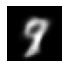

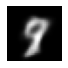

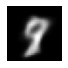

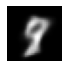

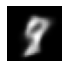

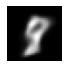

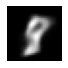

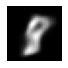

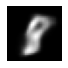

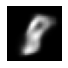

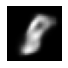

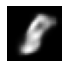

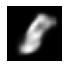

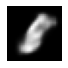

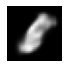

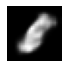

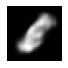

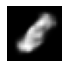

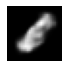

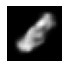

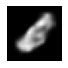

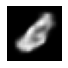

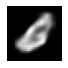

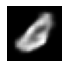

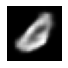

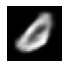

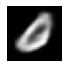

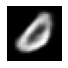

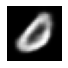

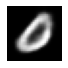

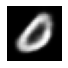

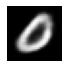

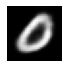

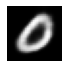

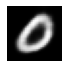

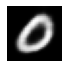

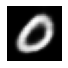

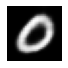

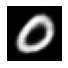

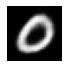

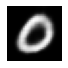

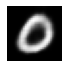

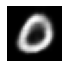

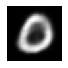

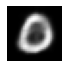

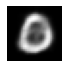

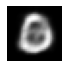

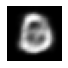

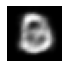

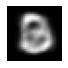

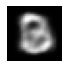

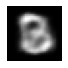

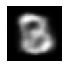

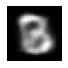

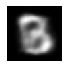

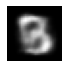

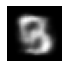

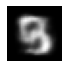

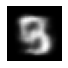

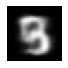

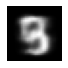

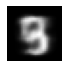

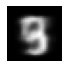

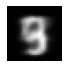

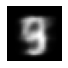

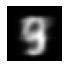

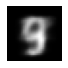

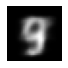

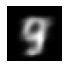

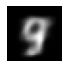

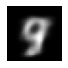

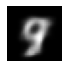

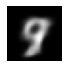

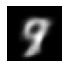

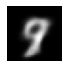

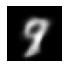

In [24]:
# 画像の保存
for i, idx in enumerate(aa):
  plt.figure(figsize=(1,1))
  plt.imshow(predictions[idx, :, :, 0], cmap='gray')
  plt.axis('off')
  plt.savefig('image_{:04d}.png'.format(i))
  plt.show()

In [25]:
# 保存した画像データを削除したいとき
filenames = glob.glob('image*.png')
filenames = sorted(filenames)
for i,filename in enumerate(filenames):
  if os.path.isfile(filename):
    os.remove(filename)